# Result analysis

In [1]:
pwd

'/Users/archnnj/Development/recsys/recsys_project/ProjectCosineTraslata/modified'

In [2]:
cd ..

/Users/archnnj/Development/recsys/recsys_project/ProjectCosineTraslata


#### Load libs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import sys, os, glob

In [4]:
from Data_manager.DataReader_ImportAll import *
from Data_manager.DataSplitter_leave_k_out import DataSplitter_leave_k_out

#### Read results metadata

In [5]:
dataset_class_list = [
    Movielens100KReader,
    Movielens1MReader,
    Movielens10MReader,
    Movielens20MReader,
    TheMoviesDatasetReader,
    #
    BrightkiteReader,
    EpinionsReader,
    NetflixPrizeReader,
    ThirtyMusicReader,
    YelpReader,
    BookCrossingReader,
    NetflixEnhancedReader,
    #
    AmazonElectronicsReader,
    AmazonBooksReader,
    AmazonAutomotiveReader,
    AmazonMoviesTVReader,
    #
    SpotifyChallenge2018Reader,
    XingChallenge2016Reader,
    XingChallenge2017Reader,
    #
    TVAudienceReader,
    LastFMHetrec2011Reader,
    # DeliciousHetrec2011Reader,
    CiteULike_aReader,
    CiteULike_tReader,
    ]

feature_weighting_list = [
    "none",
    "TF-IDF",
    "BM25"
]

allow_bias_ICM_list = [
    "original",
    "bias"
]

In [6]:
ICM_types = {
    Movielens1MReader: {
        'ICM_genres': 'binary'
    },
    Movielens10MReader: {
        'ICM_all': 'integer',
        'ICM_genres': 'binary',
        'ICM_tags': 'integer'
    },
    Movielens20MReader: {
        'ICM_all': 'integer',
        'ICM_genres': 'binary',
        'ICM_tags': 'integer'
    },
    BookCrossingReader: {
        'ICM_book_crossing': 'integer'
    },
    LastFMHetrec2011Reader: {
        'ICM_tags': 'integer'
    },
    TheMoviesDatasetReader: {
        'ICM_all': 'integer',
        'ICM_credits': 'integer',
        'ICM_metadata': 'integer'
    },
    CiteULike_aReader: {
        'ICM_title_abstract': 'float_01'
    },
    CiteULike_tReader: {
        'ICM_title_abstract': 'float_01'
    }
}

In [7]:
binary_ICMs = [(dataset_name, icm_name) 
                for dataset_name in ICM_types.keys() 
                for icm_name in ICM_types[dataset_name].keys() 
                if ICM_types[dataset_name][icm_name] == 'binary']
integer_ICMs = [(dataset_name, icm_name) 
                for dataset_name in ICM_types.keys() 
                for icm_name in ICM_types[dataset_name].keys() 
                if ICM_types[dataset_name][icm_name] == 'integer']
float_01_ICMs = [(dataset_name, icm_name) 
                for dataset_name in ICM_types.keys() 
                for icm_name in ICM_types[dataset_name].keys() 
                if ICM_types[dataset_name][icm_name] == 'float_01']
ICM_grouped_by_type = {
    'binary': binary_ICMs,
    'integer': integer_ICMs,
    'float_01': float_01_ICMs
}

In [8]:
metadata_obj = {}
for dataset_class in dataset_class_list:
    metadata_obj[dataset_class.DATASET_SUBFOLDER] = {}
    for allow_bias_ICM in allow_bias_ICM_list:
        metadata_obj[dataset_class.DATASET_SUBFOLDER][allow_bias_ICM] = {}
        for feature_weighting in feature_weighting_list:
            metadata_obj[dataset_class.DATASET_SUBFOLDER][allow_bias_ICM][feature_weighting] = {}
            for icm_name in dataset_class.AVAILABLE_ICM:
                dir_path = "./result_experiments/" + \
                        dataset_class.DATASET_SUBFOLDER + \
                        "ICM_" + allow_bias_ICM + "/" + \
                        "feature_weighting_" + feature_weighting + "/"
                file_name = "ItemKNNCBFRecommender_" + icm_name + "_cosine_metadata"
                file_path = dir_path + file_name
                
                if os.path.exists(file_path):
                    metadata = pickle.load(open(file_path, "rb" ))
                    metadata_obj[dataset_class.DATASET_SUBFOLDER][allow_bias_ICM][feature_weighting][icm_name] = metadata

##### Test if metadata read correctly

In [9]:
# E.g. original
example_dataset_class = dataset_class_list[1]
example_metadata = metadata_obj[example_dataset_class.DATASET_SUBFOLDER]["original"]["none"]["ICM_genres"]
print("best_parameters: ", example_metadata["best_parameters"], "\n")
print("best_result_validation_MAP: ", example_metadata["best_result_validation"]["MAP"], "\n")
print("best_result_test_cutoff_MAP_10", example_metadata["best_result_test"][10]["MAP"], "\n")

best_parameters:  {'topK': 70, 'shrink': 539, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'none'} 

best_result_validation_MAP:  0.0109557059010611 

best_result_test_cutoff_MAP_10 0.010235190836283745 



In [10]:
# E.g. bias
example_dataset_class = dataset_class_list[1]
example_metadata = metadata_obj[example_dataset_class.DATASET_SUBFOLDER]["bias"]["none"]["ICM_genres"]
print("best_parameters: ", example_metadata["best_parameters"], "\n")
print("best_result_validation_MAP: ", example_metadata["best_result_validation"]["MAP"], "\n")
print("best_result_test_cutoff_MAP_10", example_metadata["best_result_test"][10]["MAP"], "\n")

best_parameters:  {'topK': 145, 'shrink': 21, 'similarity': 'cosine', 'normalize': False, 'feature_weighting': 'none', 'ICM_bias': 69.02307222998205} 

best_result_validation_MAP:  0.011044940689749446 

best_result_test_cutoff_MAP_10 0.008081662316635 



##### Reminder: metadata dictionary structure

### Results analysis

#### MAP

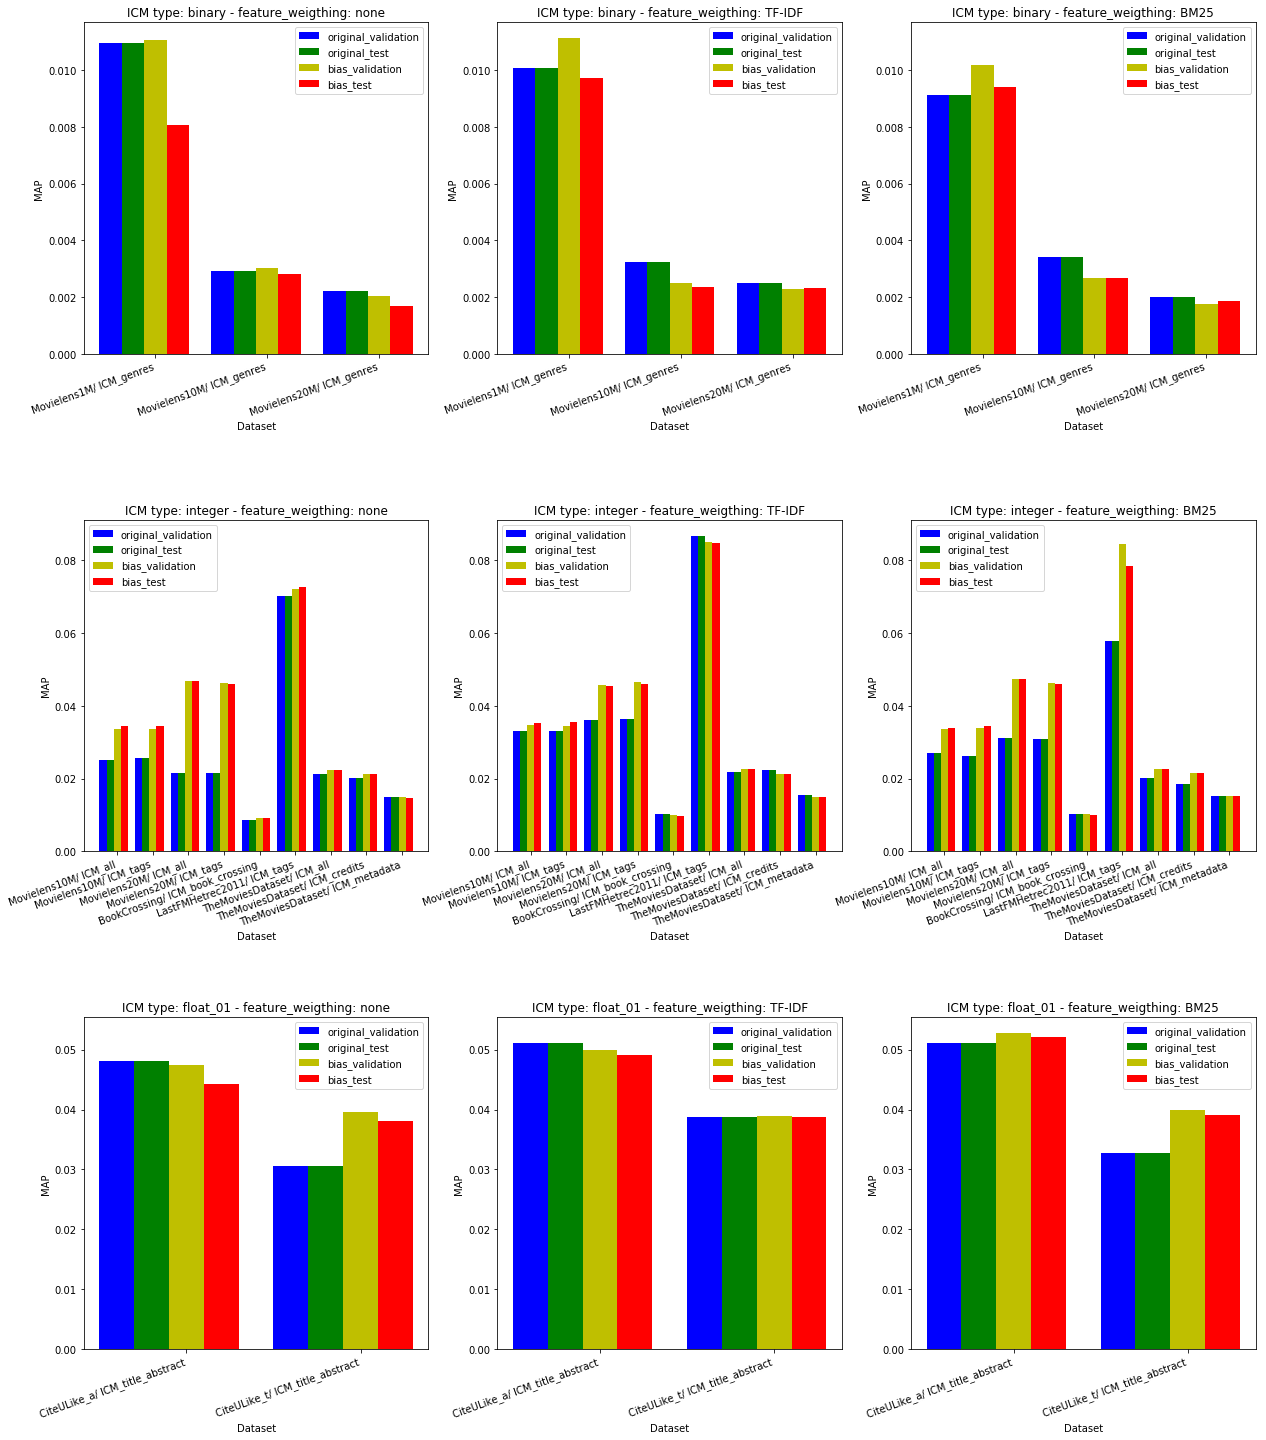

In [37]:
fixed_test_cutoff = 10

n_plot_cols = len(feature_weighting_list) # fixed for space reasons
n_plot_rows = len(ICM_grouped_by_type.keys())
n_plots = n_plot_rows * n_plot_cols

fig, axs = plt.subplots(n_plot_rows,n_plot_cols, figsize=(21, 7.8*n_plot_rows+1), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5)#, wspace=.01)
axs = axs.ravel()

for i, icm_type in enumerate(ICM_grouped_by_type.keys()):
    type_grouped_ICMs = ICM_grouped_by_type[icm_type]
    
    for j, feature_weighting in enumerate(feature_weighting_list):
        ax_idx = i * n_plot_rows + j
        
        labels = []
        original_valid_MAPs = []
        original_test_MAPs = []
        bias_valid_MAPs = []
        bias_test_MAPs = []

        for ICM_tuple in type_grouped_ICMs:
            dataset_name = ICM_tuple[0].DATASET_SUBFOLDER
            icm_name = ICM_tuple[1]
            dataset_metadata = metadata_obj[dataset_name]

            labels.append(dataset_name + " " + icm_name)
            original_valid_MAPs.append(dataset_metadata['original'][feature_weighting][icm_name]['best_result_validation']['MAP'])
            original_test_MAPs.append(dataset_metadata['original'][feature_weighting][icm_name]['best_result_test'][fixed_test_cutoff]['MAP'])
            bias_valid_MAPs.append(dataset_metadata['bias'][feature_weighting][icm_name]['best_result_validation']['MAP'])
            bias_test_MAPs.append(dataset_metadata['bias'][feature_weighting][icm_name]['best_result_test'][fixed_test_cutoff]['MAP'])

        bar_width = 0.35
        
        x_pos = np.array([i * 5*bar_width for i, _ in enumerate(labels)])
        axs[ax_idx].bar(x_pos, original_valid_MAPs, bar_width, color='b', label='original_validation')
        axs[ax_idx].bar(x_pos+1*bar_width, original_valid_MAPs, bar_width, color='g', label='original_test')
        axs[ax_idx].bar(x_pos+2*bar_width, bias_valid_MAPs, bar_width, color='y', label='bias_validation')
        axs[ax_idx].bar(x_pos+3*bar_width, bias_test_MAPs, bar_width, color='r', label='bias_test')
        axs[ax_idx].set_ylabel('MAP')
        axs[ax_idx].set_xlabel('Dataset')
        axs[ax_idx].set_xticks(x_pos+2*bar_width)
        axs[ax_idx].set_xticklabels(labels)
        axs[ax_idx].legend()
        # rotate axis labels
        plt.setp(axs[ax_idx].get_xticklabels(), rotation=20, horizontalalignment='right') # tilt x labels
        axs[ax_idx].set_title("ICM type: {} - feature_weigthing: {}".format(icm_type, feature_weighting))
    
    # set same scale to axes in row
    axes_y_lims = [axs[i * n_plot_cols + j].get_ylim() for j in range(len(feature_weighting_list))]
    axes_y_lower_lims, axes_y_upper_lims = tuple(zip(*axes_y_lims))
    axes_y_lower_lims, axes_y_upper_lims = np.array(axes_y_lower_lims), np.array(axes_y_upper_lims)
    axes_y_lim_min = np.min(axes_y_lower_lims)
    axes_y_lim_max = np.max(axes_y_upper_lims)
    for j in range(len(feature_weighting_list)):
        ax_idx = i * n_plot_cols + j
        axs[ax_idx].set_ylim([axes_y_lim_min, axes_y_lim_max])

In [38]:
# fig.savefig("Figures/results_analysis_map_samescale")

#### Delta MAP (increment adding bias)

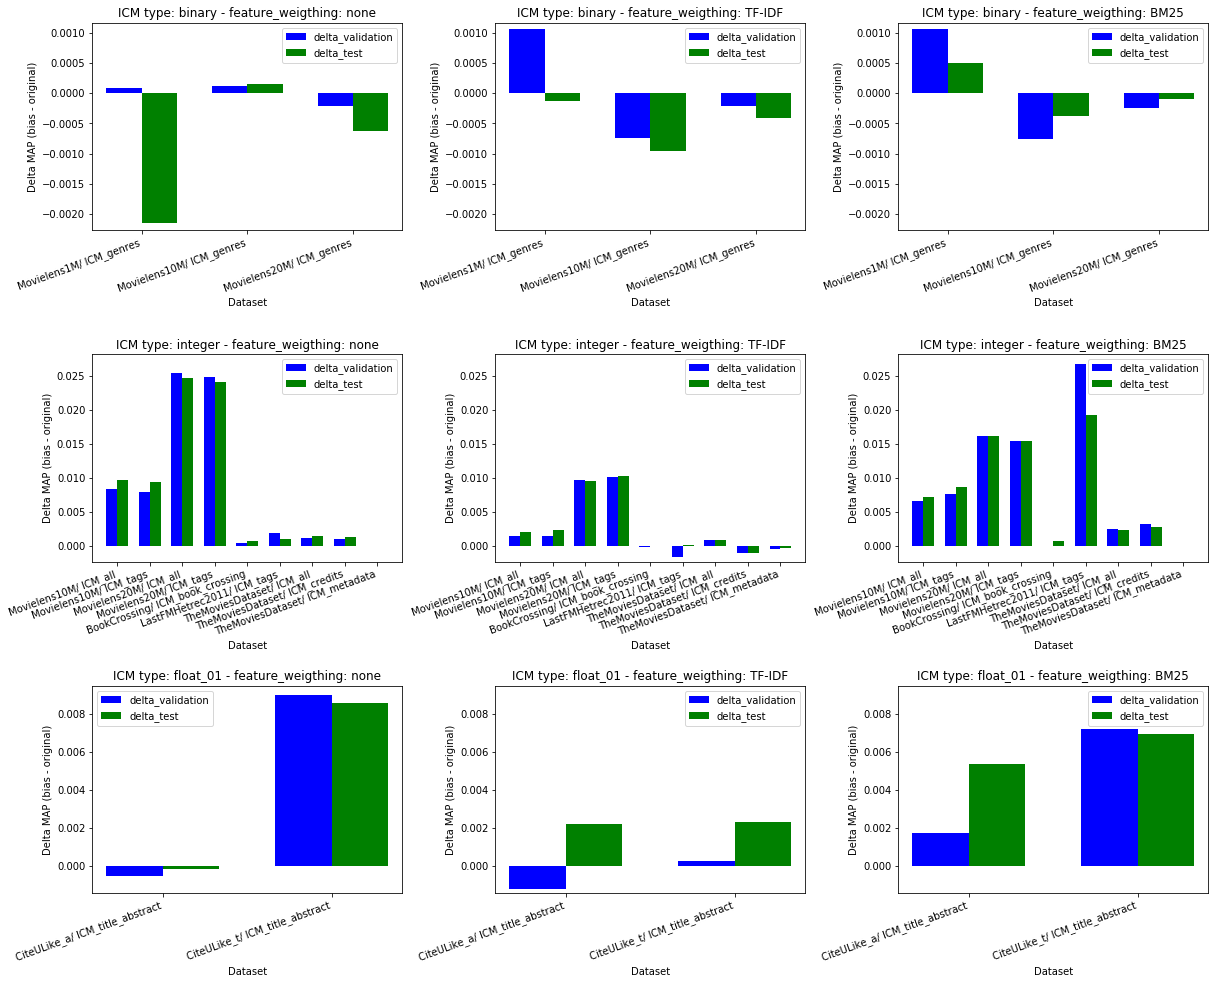

In [35]:
fixed_test_cutoff = 10

n_plot_cols = len(feature_weighting_list) # fixed for space reasons
n_plot_rows = len(ICM_grouped_by_type.keys())
n_plots = n_plot_rows * n_plot_cols

fig, axs = plt.subplots(n_plot_rows,n_plot_cols, figsize=(20, 5*n_plot_rows+1), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .6, wspace=.3)
axs = axs.ravel()

for i, icm_type in enumerate(ICM_grouped_by_type.keys()):
    type_grouped_ICMs = ICM_grouped_by_type[icm_type]

    for j, feature_weighting in enumerate(feature_weighting_list):
        ax_idx = i * n_plot_cols + j
        
        labels = []
        delta_valid_MAPs = []
        delta_test_MAPs = []

        for ICM_tuple in type_grouped_ICMs:
            dataset_name = ICM_tuple[0].DATASET_SUBFOLDER
            icm_name = ICM_tuple[1]
            dataset_metadata = metadata_obj[dataset_name]

            original_valid_MAP = dataset_metadata['original'][feature_weighting][icm_name]['best_result_validation']['MAP']
            original_test_MAP = dataset_metadata['original'][feature_weighting][icm_name]['best_result_test'][fixed_test_cutoff]['MAP']
            bias_valid_MAP = dataset_metadata['bias'][feature_weighting][icm_name]['best_result_validation']['MAP']
            bias_test_MAP = dataset_metadata['bias'][feature_weighting][icm_name]['best_result_test'][fixed_test_cutoff]['MAP']

            labels.append(dataset_name + " " + icm_name)
            delta_valid_MAPs.append(bias_valid_MAP - original_valid_MAP)
            delta_test_MAPs.append(bias_test_MAP - original_test_MAP)

        bar_width = 0.35
        x_pos = np.array([i * 3*bar_width for i, _ in enumerate(labels)])
        axs[ax_idx].bar(x_pos, delta_valid_MAPs, bar_width, color='b', label='delta_validation')
        axs[ax_idx].bar(x_pos+1*bar_width, delta_test_MAPs, bar_width, color='g', label='delta_test')
        axs[ax_idx].set_ylabel('Delta MAP (bias - original)')
        axs[ax_idx].set_xlabel('Dataset')
        axs[ax_idx].set_xticks(x_pos+0.5*bar_width)
        axs[ax_idx].set_xticklabels(labels)
        axs[ax_idx].legend()
        # rotate axis labels
        plt.setp(axs[ax_idx].get_xticklabels(), rotation=20, horizontalalignment='right') # tilt x labels
        axs[ax_idx].set_title("ICM type: {} - feature_weigthing: {}".format(icm_type, feature_weighting))
        
    # set same scale to axes in row
    axes_y_lims = [axs[i * n_plot_cols + j].get_ylim() for j in range(len(feature_weighting_list))]
    axes_y_lower_lims, axes_y_upper_lims = tuple(zip(*axes_y_lims))
    axes_y_lower_lims, axes_y_upper_lims = np.array(axes_y_lower_lims), np.array(axes_y_upper_lims)
    axes_y_lim_min = np.min(axes_y_lower_lims)
    axes_y_lim_max = np.max(axes_y_upper_lims)
    for j in range(len(feature_weighting_list)):
        ax_idx = i * n_plot_cols + j
        axs[ax_idx].set_ylim([axes_y_lim_min, axes_y_lim_max])

In [36]:
# fig.savefig("Figures/results_analysis_delta_map_samescale")

#### Relative delta MAP (relative increment adding bias, in percentage)

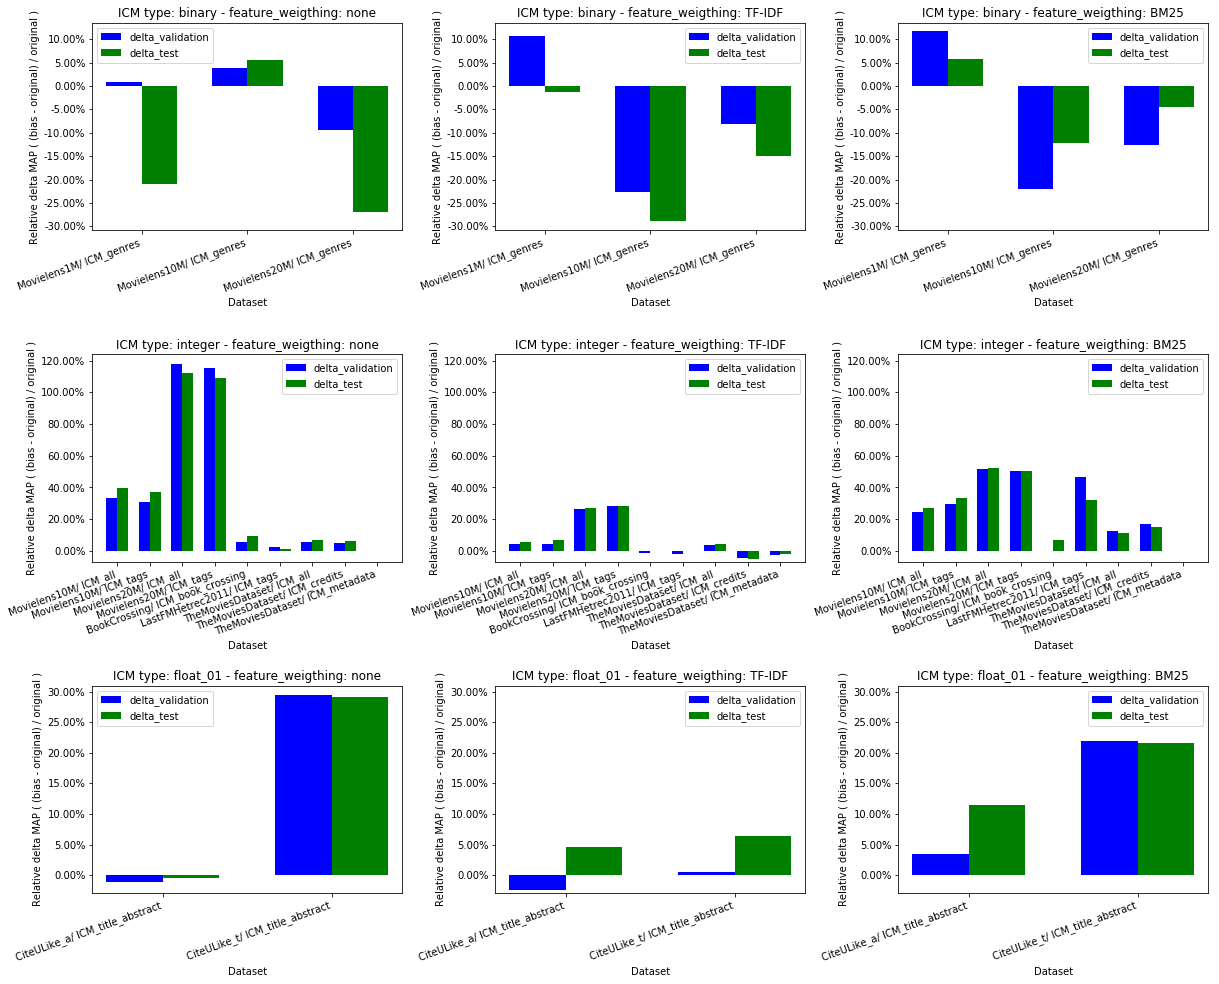

In [44]:
fixed_test_cutoff = 10

n_plot_cols = len(feature_weighting_list) # fixed for space reasons
n_plot_rows = len(ICM_grouped_by_type.keys())
n_plots = n_plot_rows * n_plot_cols

fig, axs = plt.subplots(n_plot_rows,n_plot_cols, figsize=(20, 5*n_plot_rows+1), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .6, wspace=.3)
axs = axs.ravel()

for i, icm_type in enumerate(ICM_grouped_by_type.keys()):
    type_grouped_ICMs = ICM_grouped_by_type[icm_type]

    for j, feature_weighting in enumerate(feature_weighting_list):
        ax_idx = i * n_plot_cols + j
        
        labels = []
        delta_valid_MAPs = []
        delta_test_MAPs = []

        for ICM_tuple in type_grouped_ICMs:
            dataset_name = ICM_tuple[0].DATASET_SUBFOLDER
            icm_name = ICM_tuple[1]
            dataset_metadata = metadata_obj[dataset_name]

            original_valid_MAP = dataset_metadata['original'][feature_weighting][icm_name]['best_result_validation']['MAP']
            original_test_MAP = dataset_metadata['original'][feature_weighting][icm_name]['best_result_test'][fixed_test_cutoff]['MAP']
            bias_valid_MAP = dataset_metadata['bias'][feature_weighting][icm_name]['best_result_validation']['MAP']
            bias_test_MAP = dataset_metadata['bias'][feature_weighting][icm_name]['best_result_test'][fixed_test_cutoff]['MAP']

            labels.append(dataset_name + " " + icm_name)
            delta_valid_MAPs.append( (bias_valid_MAP - original_valid_MAP) / original_valid_MAP)
            delta_test_MAPs.append((bias_test_MAP - original_test_MAP) / original_test_MAP)

        bar_width = 0.35
        x_pos = np.array([i * 3*bar_width for i, _ in enumerate(labels)])
        axs[ax_idx].bar(x_pos, delta_valid_MAPs, bar_width, color='b', label='delta_validation')
        axs[ax_idx].bar(x_pos+1*bar_width, delta_test_MAPs, bar_width, color='g', label='delta_test')
        axs[ax_idx].set_ylabel('Relative delta MAP ( (bias - original) / original )')
        axs[ax_idx].set_xlabel('Dataset')
        axs[ax_idx].set_xticks(x_pos+0.5*bar_width)
        axs[ax_idx].set_xticklabels(labels)
        axs[ax_idx].legend()
        # rotate axis labels
        plt.setp(axs[ax_idx].get_xticklabels(), rotation=20, horizontalalignment='right') # tilt x labels
        axs[ax_idx].set_title("ICM type: {} - feature_weigthing: {}".format(icm_type, feature_weighting))
        
    # set same scale to axes in row
    axes_y_lims = [axs[i * n_plot_cols + j].get_ylim() for j in range(len(feature_weighting_list))]
    axes_y_lower_lims, axes_y_upper_lims = tuple(zip(*axes_y_lims))
    axes_y_lower_lims, axes_y_upper_lims = np.array(axes_y_lower_lims), np.array(axes_y_upper_lims)
    axes_y_lim_min = np.min(axes_y_lower_lims)
    axes_y_lim_max = np.max(axes_y_upper_lims)
    for j in range(len(feature_weighting_list)):
        ax_idx = i * n_plot_cols + j
        axs[ax_idx].set_ylim([axes_y_lim_min, axes_y_lim_max])
        axs[ax_idx].set_yticklabels(['{:,.2%}'.format(x) for x in axs[ax_idx].get_yticks()])

In [45]:
# fig.savefig("Figures/results_analysis_relative_delta_map_samescale")

### Result tables

Load data and print them as tables. These can be also exported for Latex report.

#### Datasets metadata

In [11]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [12]:
def load_icm(dataset_class, ICM_name):
    with HiddenPrints():
        dataset_object = dataset_class(ICM_to_load_list = [ICM_name])
        dataSplitter = DataSplitter_leave_k_out(dataset_object, k_value=1, validation_set=True)
        dataSplitter.load_data()
        ICM_object = dataSplitter.get_ICM_from_name(ICM_name)
    return ICM_object

In [101]:
# dataset name, icm_name, icm_type, icm values set
datasets_data = []

for dataset in ICM_types.keys():
    dataset_name = dataset.DATASET_SUBFOLDER.replace("/","")
    for icm_name in ICM_types[dataset].keys():
        icm_type = ICM_types[dataset][icm_name]
        ICM = load_icm(dataset, icm_name)
        icm_values = np.unique(ICM.data)
        icm_values = np.append(icm_values, 0) # add 0 (it's a sparse matrix)
        if icm_type == "binary":
            icm_interval_s = "{0,1}"
        elif icm_type == "integer":
            icm_interval_s = "{{{:.0f},...,{:.0f}}}".format(np.min(icm_values), np.max(icm_values))
        elif icm_type == "float_01":
            icm_interval_s = "[0,1]"
            icm_type = "float" # remove _01 from label
        print("{:}, {:}, {:}, {:}".format(dataset.DATASET_SUBFOLDER.replace("/",""), icm_name, icm_type, icm_interval_s))
        datasets_data.append({'Dataset': dataset_name, 
                  'ICM name': icm_name, 
                  'ICM type': icm_type,
                  'ICM values range': icm_interval_s})
datasets_df = pd.DataFrame(datasets_data)
datasets_df

Movielens1M, ICM_genres, binary, {0,1}
Movielens10M, ICM_all, integer, {0,...,69}
Movielens10M, ICM_genres, binary, {0,1}
Movielens10M, ICM_tags, integer, {0,...,69}
Movielens20M, ICM_all, integer, {0,...,257}
Movielens20M, ICM_genres, binary, {0,1}
Movielens20M, ICM_tags, integer, {0,...,257}
BookCrossing, ICM_book_crossing, integer, {0,...,7}
LastFMHetrec2011, ICM_tags, integer, {0,...,108}
TheMoviesDataset, ICM_all, integer, {0,...,10}
TheMoviesDataset, ICM_credits, integer, {0,...,10}
TheMoviesDataset, ICM_metadata, integer, {0,...,3}
CiteULike_a, ICM_title_abstract, float, [0,1]
CiteULike_t, ICM_title_abstract, float, [0,1]


,Dataset,ICM name,ICM type,ICM values range
0,Movielens1M,ICM_genres,binary,"{0,1}"
1,Movielens10M,ICM_all,integer,"{0,...,69}"
2,Movielens10M,ICM_genres,binary,"{0,1}"
3,Movielens10M,ICM_tags,integer,"{0,...,69}"
4,Movielens20M,ICM_all,integer,"{0,...,257}"
5,Movielens20M,ICM_genres,binary,"{0,1}"
6,Movielens20M,ICM_tags,integer,"{0,...,257}"
7,BookCrossing,ICM_book_crossing,integer,"{0,...,7}"
8,LastFMHetrec2011,ICM_tags,integer,"{0,...,108}"
9,TheMoviesDataset,ICM_all,integer,"{0,...,10}"


In [102]:
print(datasets_df.to_latex(index=False))

\begin{tabular}{llll}
\toprule
          Dataset &            ICM name & ICM type & ICM values range \\
\midrule
      Movielens1M &          ICM\_genres &   binary &            \{0,1\} \\
     Movielens10M &             ICM\_all &  integer &       \{0,...,69\} \\
     Movielens10M &          ICM\_genres &   binary &            \{0,1\} \\
     Movielens10M &            ICM\_tags &  integer &       \{0,...,69\} \\
     Movielens20M &             ICM\_all &  integer &      \{0,...,257\} \\
     Movielens20M &          ICM\_genres &   binary &            \{0,1\} \\
     Movielens20M &            ICM\_tags &  integer &      \{0,...,257\} \\
     BookCrossing &   ICM\_book\_crossing &  integer &        \{0,...,7\} \\
 LastFMHetrec2011 &            ICM\_tags &  integer &      \{0,...,108\} \\
 TheMoviesDataset &             ICM\_all &  integer &       \{0,...,10\} \\
 TheMoviesDataset &         ICM\_credits &  integer &       \{0,...,10\} \\
 TheMoviesDataset &        ICM\_metadata &  intege

#### Experimental results: MAP performance

In [137]:
# dataset name, icm_name, icm_type, icm values set
fixed_test_cutoff = 10

d = []

for dataset in ICM_types.keys():
    dataset_name = dataset.DATASET_SUBFOLDER.replace("/","")
    dataset_metadata = metadata_obj[dataset.DATASET_SUBFOLDER]
    for icm_name in ICM_types[dataset].keys():
        icm_type = datasets_df[(datasets_df['Dataset'] == dataset_name) & (datasets_df['ICM name'] == icm_name)]['ICM type'].tolist()[0]
        icm_interval_s = datasets_df[(datasets_df['Dataset'] == dataset_name) & (datasets_df['ICM name'] == icm_name)]['ICM values range'].tolist()[0]
        
        for allow_bias_ICM in allow_bias_ICM_list:
            for feature_weighting in feature_weighting_list:
                
                best_params = dataset_metadata[allow_bias_ICM][feature_weighting][icm_name]['best_parameters']
                valid_MAP = dataset_metadata[allow_bias_ICM][feature_weighting][icm_name]['best_result_validation']['MAP']
                test_MAP = dataset_metadata[allow_bias_ICM][feature_weighting][icm_name]['best_result_test'][fixed_test_cutoff]['MAP']
                
                train_time = dataset_metadata[allow_bias_ICM][feature_weighting][icm_name]['train_time_total']
                valid_time = dataset_metadata[allow_bias_ICM][feature_weighting][icm_name]['evaluation_time_total']
                test_time = dataset_metadata[allow_bias_ICM][feature_weighting][icm_name]['evaluation_test_time_total']

                d.append({'Dataset': dataset_name, 
                          'ICM': icm_name,
                          'ICM type': icm_type,
                          'ICM range': icm_interval_s,
                          'F.Weight': feature_weighting,
                          'Bias': 'Yes' if allow_bias_ICM == 'bias' else 'No',
                          'Best params': best_params,
                          'ValidMAP@10': valid_MAP,
                          'TestMAP@10': test_MAP,
                          'Train t (sec)': train_time,
                          'Validation t (sec)': valid_time,
                          'Test t (sec)': test_time
                         })
df = pd.DataFrame(d)
df

,Best params,Bias,Dataset,F.Weight,ICM,ICM range,ICM type,Test t (sec),TestMAP@10,Train t (sec),ValidMAP@10,Validation t (sec)
0,"{'topK': 70, 'shrink': 539, 'similarity': 'cos...",No,Movielens1M,none,ICM_genres,"{0,1}",binary,34.060542,0.010235,21.712395,0.010956,185.097947
1,"{'topK': 791, 'shrink': 23, 'similarity': 'cos...",No,Movielens1M,TF-IDF,ICM_genres,"{0,1}",binary,55.793151,0.009837,21.005989,0.010060,172.642236
2,"{'topK': 11, 'shrink': 2, 'similarity': 'cosin...",No,Movielens1M,BM25,ICM_genres,"{0,1}",binary,87.402515,0.008907,19.461136,0.009126,149.406416
3,"{'topK': 145, 'shrink': 21, 'similarity': 'cos...",Yes,Movielens1M,none,ICM_genres,"{0,1}",binary,26.388714,0.008082,19.743082,0.011045,168.892770
4,"{'topK': 199, 'shrink': 1, 'similarity': 'cosi...",Yes,Movielens1M,TF-IDF,ICM_genres,"{0,1}",binary,12.827838,0.009715,19.944537,0.011124,167.526733
5,"{'topK': 199, 'shrink': 1, 'similarity': 'cosi...",Yes,Movielens1M,BM25,ICM_genres,"{0,1}",binary,12.576593,0.009412,20.488702,0.010198,162.447871
6,"{'topK': 19, 'shrink': 0, 'similarity': 'cosin...",No,Movielens10M,none,ICM_all,"{0,...,69}",integer,798.356572,0.024607,189.463541,0.025202,5372.853196
7,"{'topK': 794, 'shrink': 994, 'similarity': 'co...",No,Movielens10M,TF-IDF,ICM_all,"{0,...,69}",integer,1093.228535,0.033374,134.003183,0.033212,3584.996208
8,"{'topK': 800, 'shrink': 981, 'similarity': 'co...",No,Movielens10M,BM25,ICM_all,"{0,...,69}",integer,1662.443463,0.026724,198.034570,0.026939,4793.643505
9,"{'topK': 41, 'shrink': 13, 'similarity': 'cosi...",Yes,Movielens10M,none,ICM_all,"{0,...,69}",integer,793.091786,0.034330,167.464839,0.033556,4294.723866


In [131]:
print_columns=['Dataset',
         'ICM',
         #'ICM type',
         'ICM range',
         'F.Weight',
         'Bias',
         #'Best params': best_params,
         'ValidMAP@10',
         'TestMAP@10',
         'Train t (sec)',
         'Validation t (sec)',
         'Test t (sec)']
sort_columns=['Dataset',
              'ICM',
              'F.Weight',
              'Bias']
print(df.astype({'Train t (sec)':int, 'Validation t (sec)':int, 'Test t (sec)':int})
      .sort_values(by=sort_columns)
      .to_latex(longtable=True,
                  index=False,
                  columns=print_columns))

\begin{longtable}{lllllrrrrr}
\toprule
          Dataset &                 ICM &    ICM range & F.Weight & Bias &  ValidMAP@10 &  TestMAP@10 &  Train t (sec) &  Validation t (sec) &  Test t (sec) \\
\midrule
\endhead
\midrule
\multicolumn{10}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
     BookCrossing &   ICM\_book\_crossing &    \{0,...,7\} &     BM25 &   No &     0.010251 &    0.009226 &          47261 &               75699 &          2855 \\
     BookCrossing &   ICM\_book\_crossing &    \{0,...,7\} &     BM25 &  Yes &     0.010240 &    0.009875 &          34493 &               58940 &          2436 \\
     BookCrossing &   ICM\_book\_crossing &    \{0,...,7\} &   TF-IDF &   No &     0.010223 &    0.009853 &          42124 &               61405 &          3554 \\
     BookCrossing &   ICM\_book\_crossing &    \{0,...,7\} &   TF-IDF &  Yes &     0.010063 &    0.009830 &          39325 &               58551 &          4001 \\
     BookCrossing &   ICM

#### Experimental results: best parameters

Reminder - parameters structure example:

{'topK': 44,
 'shrink': 5,
 'similarity': 'cosine',
 'normalize': False,
 'feature_weighting': 'BM25',
 'ICM_bias': 934.206227699317}

In [185]:
# dataset name, icm_name, icm_type, icm values set
fixed_test_cutoff = 10

d = []
best_params_d = []
best_params_labels = []
best_params_new_labels = []

for dataset in ICM_types.keys():
    dataset_name = dataset.DATASET_SUBFOLDER.replace("/","")
    dataset_metadata = metadata_obj[dataset.DATASET_SUBFOLDER]
    for icm_name in ICM_types[dataset].keys():
        icm_type = datasets_df[(datasets_df['Dataset'] == dataset_name) & (datasets_df['ICM name'] == icm_name)]['ICM type'].tolist()[0]
        icm_interval_s = datasets_df[(datasets_df['Dataset'] == dataset_name) & (datasets_df['ICM name'] == icm_name)]['ICM values range'].tolist()[0]
        
        for allow_bias_ICM in allow_bias_ICM_list:
            for feature_weighting in feature_weighting_list:
                
                best_params = dataset_metadata[allow_bias_ICM][feature_weighting][icm_name]['best_parameters']
                valid_MAP = dataset_metadata[allow_bias_ICM][feature_weighting][icm_name]['best_result_validation']['MAP']
                test_MAP = dataset_metadata[allow_bias_ICM][feature_weighting][icm_name]['best_result_test'][fixed_test_cutoff]['MAP']
                
                train_time = dataset_metadata[allow_bias_ICM][feature_weighting][icm_name]['train_time_total']
                valid_time = dataset_metadata[allow_bias_ICM][feature_weighting][icm_name]['evaluation_time_total']
                test_time = dataset_metadata[allow_bias_ICM][feature_weighting][icm_name]['evaluation_test_time_total']

                best_params_d.append(best_params)
                best_params_labels = list(best_params.keys())
                best_params_relabeled = dict((key, value) for (key, value) in best_params.items())
                best_params_new_labels = list(best_params_relabeled.keys())
                
                data = {'Dataset': dataset_name, 
                          'ICM': icm_name,
                          'ICM type': icm_type,
                          'ICM range': icm_interval_s,
                          'F.Weight': feature_weighting,
                          'Bias': 'Yes' if allow_bias_ICM == 'bias' else 'No',
                          'BestParams': best_params,
                          'ValidMAP@10': valid_MAP,
                          'TestMAP@10': test_MAP,
                          'Train t (sec)': train_time,
                          'Validation t (sec)': valid_time,
                          'Test t (sec)': test_time,
                          'TopK': best_params['topK'],
                          'Shrink': best_params['shrink'],
                          'Normalize': 'Yes' if best_params['normalize'] else 'No',
                          'Bias val': best_params['ICM_bias'] if allow_bias_ICM == "bias" else "-"
                         }
                data.update(best_params_relabeled)
                d.append(data)
df = pd.DataFrame(d)
#df

In [189]:
print_columns=['Dataset',
         'ICM',
         #'ICM type',
         'ICM range',
         'F.Weight',
         'Bias',
         'TopK',
         'Shrink',
         'Normalize',
         'Bias val',
         #'Best params',
         #'ValidMAP@10',
         #'TestMAP@10',
         #'Train t (sec)',
         #'Validation t (sec)',
         #'Test t (sec)'
]
sort_columns=['Dataset',
              'ICM',
              'F.Weight',
              'Bias']
print(df.astype({'Train t (sec)':int, 'Validation t (sec)':int, 'Test t (sec)':int})
      .sort_values(by=sort_columns)
      .to_latex(longtable=True,
                  index=False,
                  columns=print_columns))

\begin{longtable}{lllllrrll}
\toprule
          Dataset &                 ICM &    ICM range & F.Weight & Bias &  TopK &  Shrink & Normalize &   Bias val \\
\midrule
\endhead
\midrule
\multicolumn{9}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
     BookCrossing &   ICM\_book\_crossing &    \{0,...,7\} &     BM25 &   No &    13 &     996 &       Yes &          - \\
     BookCrossing &   ICM\_book\_crossing &    \{0,...,7\} &     BM25 &  Yes &    17 &      14 &        No &    847.931 \\
     BookCrossing &   ICM\_book\_crossing &    \{0,...,7\} &   TF-IDF &   No &    13 &     996 &       Yes &          - \\
     BookCrossing &   ICM\_book\_crossing &    \{0,...,7\} &   TF-IDF &  Yes &    17 &      14 &        No &    847.931 \\
     BookCrossing &   ICM\_book\_crossing &    \{0,...,7\} &     none &   No &   794 &       7 &       Yes &          - \\
     BookCrossing &   ICM\_book\_crossing &    \{0,...,7\} &     none &  Yes &   782 &      80 &       Yes & 